In [3]:
import valjax as vj

In [110]:
import jax
import jax.numpy as np
from jax import lax

In [25]:
plt = plotter()
%matplotlib inline

In [339]:
β = 0.95
δ = 0.1
α = 0.35
z = np.array([1, 1.2, 1.4])

In [340]:
k_lim = (z/δ)**(1/(1-α))
print(f'k_lim = {k_lim}')

k_lim = [34.551075 45.73818  57.979427]


In [341]:
def util(c, eps=1e-6):
    c1 = np.maximum(eps, c)
    return np.log(c1)

In [342]:
def prod(z, k):
    return z*k**α

In [343]:
k_min = 0.2
k_max = 10.0
N = 100

In [344]:
k_grid = np.linspace(k_min, k_max, N)
y_grid = prod(z[:,None], k_grid[None,:])
yd_grid = y_grid + (1-δ)*k_grid[None,:]

In [345]:
def value(vn, tv):
    cp = yd_grid[:,:,None] - k_grid[None,None,:]
    vp = util(cp) + β*vn[:,None,:]
    ip = vj.smoothmax(vp, (-1,))
    kp = vj.interp(k_grid, ip)
    v = vj.interp_address(vp, ip, (-1,))
    return v, {'v': v, 'kp': kp}

In [346]:
val0 = util(y_grid)
st0 = np.arange(50)
last, path = lax.scan(value, val0, st0)

In [347]:
path['kp'].shape

(50, 3, 100)

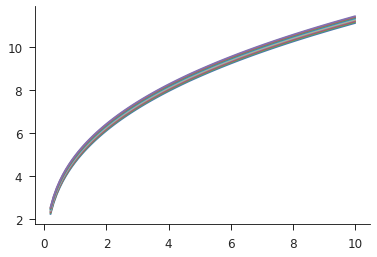

In [358]:
plt.plot(k_grid, path['v'][-10:,1,:].T);

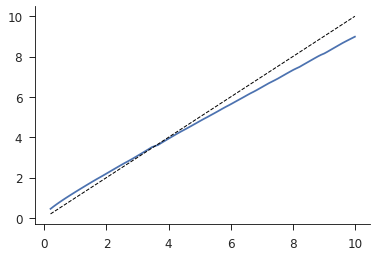

In [351]:
plt.plot(k_grid, path['kp'][50,0,:].T);
plt.plot(k_grid, k_grid, linewidth=1, linestyle='--', c='k');